In [1]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import itertools

from torch.utils.data import DataLoader
from torch import nn
from sklearn.metrics import mean_absolute_error, median_absolute_error, mean_squared_error

sys.path.append("..")
from utils import metrics
from utils.data import TimeFusionDataset
from timefusion import TimeFusion
from utils.early_stopper import EarlyStopper

In [2]:
# Import data
train_data = pd.read_csv("../../datasets/electricity/train.csv").set_index("date")
test_data = pd.read_csv("../../datasets/electricity/test.csv").set_index("date")
train_data = train_data.iloc[:,:30]
test_data = test_data.iloc[:,:30]

# Normalize the signal power of each column
stds = train_data.std()
train_data /= stds
test_data /= stds

In [3]:
# Compute device
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")

In [4]:
context_length = 96
prediction_length = 24

# Create datasets
train_dataset = TimeFusionDataset(
    data = train_data.iloc[:int(0.9*len(train_data))],
    context_length = context_length,
)
train_dataset.add_timestamp_encodings()

val_dataset = TimeFusionDataset(
    data = train_data.iloc[int(0.9*len(train_data)):],
    context_length = context_length,
)
val_dataset.add_timestamp_encodings()

test_dataset = TimeFusionDataset(
    data = test_data,
    context_length = context_length,
)
test_dataset.add_timestamp_encodings()

train_loader = DataLoader(
    dataset = train_dataset,
    shuffle = True,
    num_workers = 4,
    batch_size = 128,
)

val_loader = DataLoader(
    dataset = val_dataset,
    shuffle = True,
    num_workers = 4,
    batch_size = 128,
)

In [5]:
predictor = TimeFusion(
    input_size = train_dataset.data.shape[1],
    output_size = train_data.shape[1],
    rnn_layers = 2,
    rnn_hidden = 40,
    autoencoder_layers = 2,
    autoencoder_latent = 300,
    scaling = True,
    device = device
)

print("Number of trainable parameters:",sum(p.numel() for p in predictor.parameters()))

/rds/general/user/ejh19/home/Final-Year-Project/TimeFusion/examples/../utils/diffusion.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.bar_alphas = torch.tensor(


Number of trainable parameters: 114450


In [6]:
optimizer = torch.optim.Adam(params=predictor.parameters(),lr=5e-4)
lr_scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=1, end_factor=0.01, total_iters=40)

predictor.train_network(
    train_loader = train_loader,
    epochs=40,
    val_loader = val_loader,
    val_metrics= {
        "Val MAE": nn.L1Loss(),
    },
    optimizer = optimizer,
    lr_scheduler= lr_scheduler,
    early_stopper=EarlyStopper(patience=20),
    save_weights = True,
    weight_folder = "weights/electricity"
)

Epoch: 1/40: 100%|██████████| 169/169 [00:01<00:00, 129.69batch/s, Training loss=0.5492]


Val MAE: 0.3673 , val_loss: 0.2646 , 


Epoch: 2/40: 100%|██████████| 169/169 [00:01<00:00, 147.68batch/s, Training loss=0.2154]


Val MAE: 0.2850 , val_loss: 0.1914 , 


Epoch: 3/40: 100%|██████████| 169/169 [00:01<00:00, 148.58batch/s, Training loss=0.1819]


Val MAE: 0.2648 , val_loss: 0.1734 , 


Epoch: 4/40: 100%|██████████| 169/169 [00:01<00:00, 148.69batch/s, Training loss=0.1719]


Val MAE: 0.2604 , val_loss: 0.1695 , 


Epoch: 5/40: 100%|██████████| 169/169 [00:01<00:00, 147.36batch/s, Training loss=0.1653]


Val MAE: 0.2487 , val_loss: 0.1560 , 


Epoch: 6/40: 100%|██████████| 169/169 [00:01<00:00, 147.30batch/s, Training loss=0.1586]


Val MAE: 0.2631 , val_loss: 0.1780 , 


Epoch: 7/40: 100%|██████████| 169/169 [00:01<00:00, 147.62batch/s, Training loss=0.1489]


Val MAE: 0.2435 , val_loss: 0.1581 , 


Epoch: 8/40: 100%|██████████| 169/169 [00:01<00:00, 148.60batch/s, Training loss=0.1504]


Val MAE: 0.2308 , val_loss: 0.1455 , 


Epoch: 9/40: 100%|██████████| 169/169 [00:01<00:00, 148.62batch/s, Training loss=0.1406]


Val MAE: 0.2250 , val_loss: 0.1395 , 


Epoch: 10/40: 100%|██████████| 169/169 [00:01<00:00, 148.21batch/s, Training loss=0.1405]


Val MAE: 0.2243 , val_loss: 0.1392 , 


Epoch: 11/40: 100%|██████████| 169/169 [00:01<00:00, 147.36batch/s, Training loss=0.1369]


Val MAE: 0.2111 , val_loss: 0.1272 , 


Epoch: 12/40: 100%|██████████| 169/169 [00:01<00:00, 148.95batch/s, Training loss=0.1311]


Val MAE: 0.2222 , val_loss: 0.1460 , 


Epoch: 13/40: 100%|██████████| 169/169 [00:01<00:00, 149.20batch/s, Training loss=0.1320]


Val MAE: 0.2188 , val_loss: 0.1364 , 


Epoch: 14/40: 100%|██████████| 169/169 [00:01<00:00, 136.73batch/s, Training loss=0.1295]


Val MAE: 0.2064 , val_loss: 0.1259 , 


Epoch: 15/40: 100%|██████████| 169/169 [00:01<00:00, 142.03batch/s, Training loss=0.1275]


Val MAE: 0.2146 , val_loss: 0.1314 , 


Epoch: 16/40: 100%|██████████| 169/169 [00:01<00:00, 142.85batch/s, Training loss=0.1269]


Val MAE: 0.2050 , val_loss: 0.1255 , 


Epoch: 17/40: 100%|██████████| 169/169 [00:01<00:00, 139.55batch/s, Training loss=0.1246]


Val MAE: 0.2086 , val_loss: 0.1302 , 


Epoch: 18/40: 100%|██████████| 169/169 [00:01<00:00, 143.64batch/s, Training loss=0.1274]


Val MAE: 0.2011 , val_loss: 0.1253 , 


Epoch: 19/40: 100%|██████████| 169/169 [00:01<00:00, 144.22batch/s, Training loss=0.1247]


Val MAE: 0.1961 , val_loss: 0.1217 , 


Epoch: 20/40: 100%|██████████| 169/169 [00:01<00:00, 142.96batch/s, Training loss=0.1265]


Val MAE: 0.2102 , val_loss: 0.1347 , 


Epoch: 21/40: 100%|██████████| 169/169 [00:01<00:00, 144.73batch/s, Training loss=0.1260]


Val MAE: 0.2008 , val_loss: 0.1237 , 


Epoch: 22/40: 100%|██████████| 169/169 [00:01<00:00, 145.02batch/s, Training loss=0.1207]


Val MAE: 0.2113 , val_loss: 0.1366 , 


Epoch: 23/40: 100%|██████████| 169/169 [00:01<00:00, 143.11batch/s, Training loss=0.1220]


Val MAE: 0.1928 , val_loss: 0.1165 , 


Epoch: 24/40: 100%|██████████| 169/169 [00:01<00:00, 146.13batch/s, Training loss=0.1223]


Val MAE: 0.2035 , val_loss: 0.1255 , 


Epoch: 25/40: 100%|██████████| 169/169 [00:01<00:00, 145.12batch/s, Training loss=0.1214]


Val MAE: 0.2025 , val_loss: 0.1286 , 


Epoch: 26/40: 100%|██████████| 169/169 [00:01<00:00, 144.85batch/s, Training loss=0.1230]


Val MAE: 0.2044 , val_loss: 0.1274 , 


Epoch: 27/40: 100%|██████████| 169/169 [00:01<00:00, 144.89batch/s, Training loss=0.1195]


Val MAE: 0.2046 , val_loss: 0.1354 , 


Epoch: 28/40: 100%|██████████| 169/169 [00:01<00:00, 145.52batch/s, Training loss=0.1193]


Val MAE: 0.1967 , val_loss: 0.1252 , 


Epoch: 29/40: 100%|██████████| 169/169 [00:01<00:00, 144.84batch/s, Training loss=0.1193]


Val MAE: 0.2021 , val_loss: 0.1320 , 


Epoch: 30/40: 100%|██████████| 169/169 [00:01<00:00, 146.12batch/s, Training loss=0.1211]


Val MAE: 0.1914 , val_loss: 0.1218 , 


Epoch: 31/40: 100%|██████████| 169/169 [00:01<00:00, 145.67batch/s, Training loss=0.1191]


Val MAE: 0.1958 , val_loss: 0.1252 , 


Epoch: 32/40: 100%|██████████| 169/169 [00:01<00:00, 146.47batch/s, Training loss=0.1184]


Val MAE: 0.1950 , val_loss: 0.1154 , 


Epoch: 33/40: 100%|██████████| 169/169 [00:01<00:00, 146.07batch/s, Training loss=0.1173]


Val MAE: 0.1977 , val_loss: 0.1258 , 


Epoch: 34/40: 100%|██████████| 169/169 [00:01<00:00, 146.43batch/s, Training loss=0.1197]


Val MAE: 0.1877 , val_loss: 0.1146 , 


Epoch: 35/40: 100%|██████████| 169/169 [00:01<00:00, 146.95batch/s, Training loss=0.1168]


Val MAE: 0.1967 , val_loss: 0.1285 , 


Epoch: 36/40: 100%|██████████| 169/169 [00:01<00:00, 145.56batch/s, Training loss=0.1169]


Val MAE: 0.2015 , val_loss: 0.1329 , 


Epoch: 37/40: 100%|██████████| 169/169 [00:01<00:00, 147.88batch/s, Training loss=0.1159]


Val MAE: 0.1898 , val_loss: 0.1237 , 


Epoch: 38/40: 100%|██████████| 169/169 [00:01<00:00, 147.02batch/s, Training loss=0.1150]


Val MAE: 0.1894 , val_loss: 0.1174 , 


Epoch: 39/40: 100%|██████████| 169/169 [00:01<00:00, 148.57batch/s, Training loss=0.1156]


Val MAE: 0.2030 , val_loss: 0.1397 , 


Epoch: 40/40: 100%|██████████| 169/169 [00:01<00:00, 148.04batch/s, Training loss=0.1166]


Val MAE: 0.1956 , val_loss: 0.1218 , 


In [7]:
# Load weights as an alternative to training
# predictor.load_state_dict(torch.load("weights/electricity/2023-05-24-18-26-53"))
# predictor.eval()

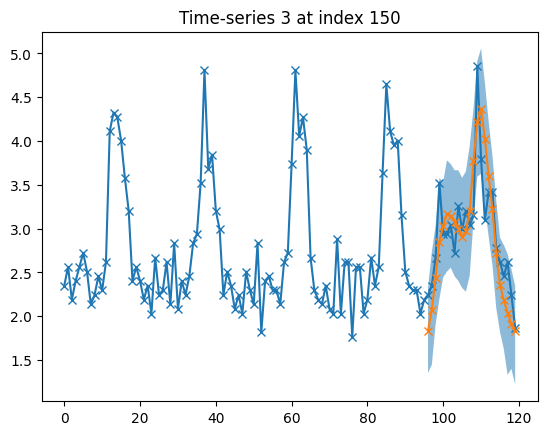

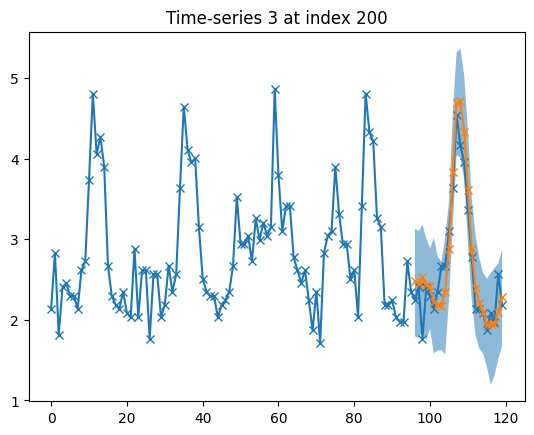

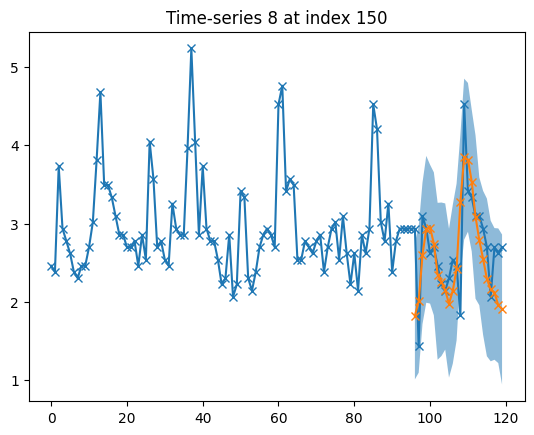

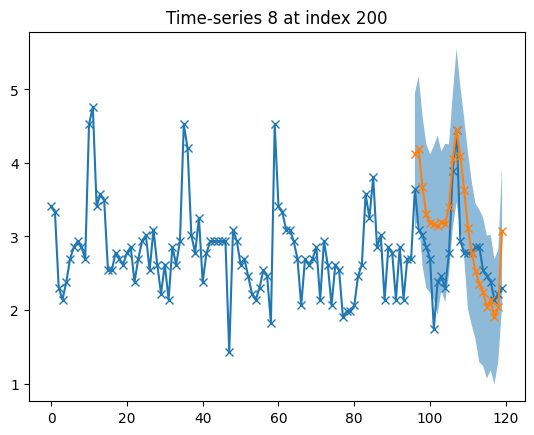

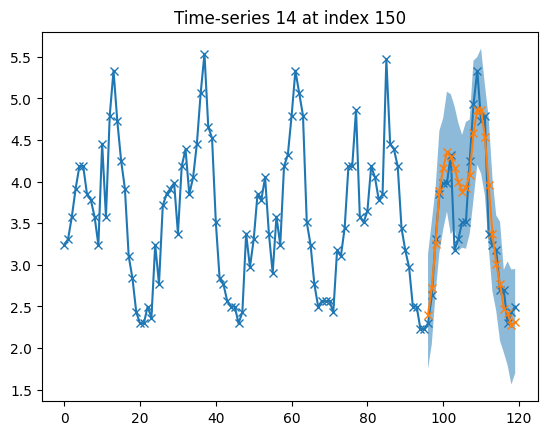

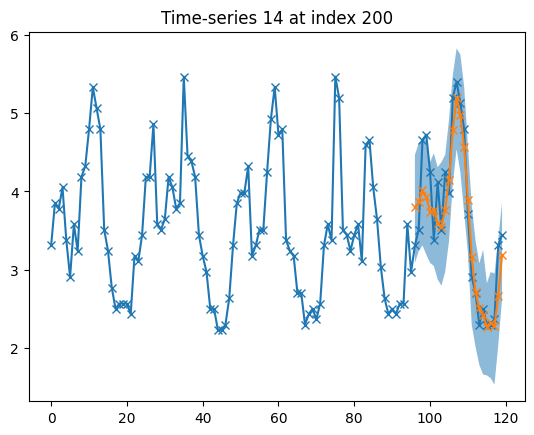

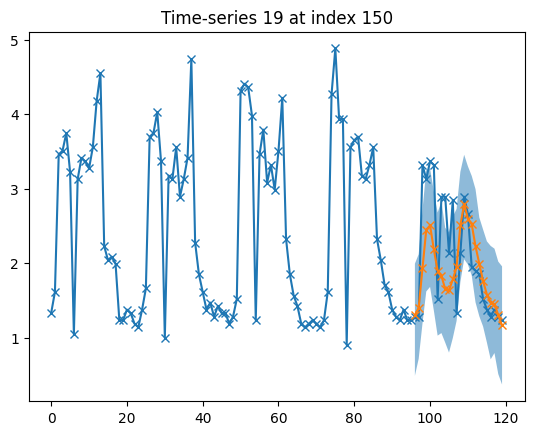

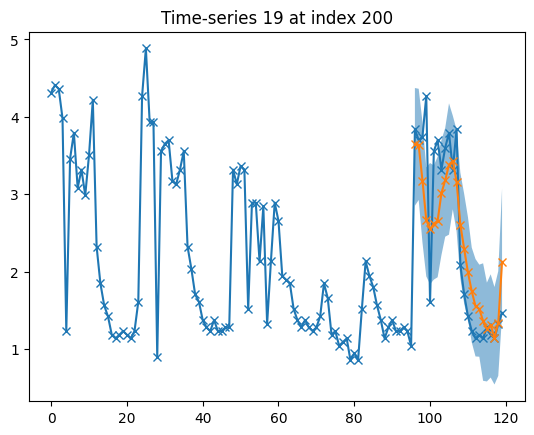

In [8]:
# Sample from model
indices = [150,200]

samples = predictor.sample(
    data = test_dataset,
    indices = indices,
    prediction_length = prediction_length,
    num_samples = 128,
    batch_size = 128,
)
samples = samples.cpu()

# Sort samples in ascending order
samples = samples.permute(0,2,3,1).flatten(start_dim=0,end_dim=2).sort()[0].reshape(samples.shape[0],samples.shape[2],samples.shape[3],-1).permute(0,3,1,2)

# Plot some predictions
confidence = 0.9
for ts, i in itertools.product([3,8,14,19],range(len(indices))):
    plt.figure()
    plt.title(f"Time-series {ts} at index {indices[i]}")
    plt.plot(test_dataset.tensor_data[indices[i]:indices[i]+context_length+prediction_length,ts],"-x")
    plt.plot(list(range(context_length,context_length+prediction_length)),torch.mean(samples[i,:,ts],dim = 0),"-x")
    plt.fill_between(list(range(context_length,context_length+prediction_length)), samples[i,int(confidence*samples.shape[1]),ts], samples[i,int((1-confidence)*samples.shape[1]),ts],alpha=0.5)
    #plt.savefig(f"images/no_shift_{idx}_{ts}.png")

In [9]:
# Make samples and extract realisations for last 14 days of test dataset
indices = list(range(0, 24*2, 24))

samples = predictor.sample(
    data = test_dataset,
    indices = indices,
    prediction_length = prediction_length,
    num_samples = 128,
    batch_size = 128,
)
samples = samples.cpu().numpy()


realisations = []
for idx in indices:
    realisations.append(
        test_data.values[context_length + idx:context_length + idx + prediction_length].T
    )
realisations = np.stack(realisations)


In [10]:
# Calculate metrics
mean_predictions = samples.mean(axis=1)

# MSE, MAE, MDAE
mse = mean_squared_error(realisations.flatten(), mean_predictions.flatten())
mae = mean_absolute_error(realisations.flatten(), mean_predictions.flatten())
mdae = median_absolute_error(realisations.flatten(), mean_predictions.flatten())
print("MSE:", mse, "MAE:", mae, "MDAE:", mdae)

# CRPS_sum and Variogram_score
crps_sum = np.mean([metrics.crps_sum(samples[i], realisations[i]) for i in range(realisations.shape[0])])
variogram_score = np.mean([metrics.variogram_score(samples[i], realisations[i], weights="local", window_size=3) for i in range(realisations.shape[0])])
print("CRPS_sum:", crps_sum, "Variogram_score:", variogram_score)

MSE: 0.184733920738412 MAE: 0.31136923759560886 MDAE: 0.2288381854601904
CRPS_sum: 2.748764579494794 Variogram_score: 0.06966348299053798
